# Algoritmi de Deconvolutie

### Pachetele necesare

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import cv2 as cv
from scipy.special import j1 as bessel1D
from scipy.fftpack import fft2, fftshift, ifft2, ifftshift
import scipy.stats as st
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from math import log

### Functie ce adauga blurul unei imagini, folosind transformata Fourier si inversa transformatei Fourier

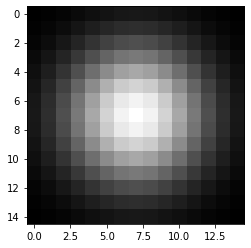

In [100]:
def gaussianKernel(kernelLen, sigma):
    range = (2 * sigma + 1.)/(kernelLen)
    points = np.linspace(-sigma - range/2., sigma + range/2., kernelLen + 1)
    kernel = np.diff(st.norm.cdf(points))
    kernel = np.sqrt(np.outer(kernel, kernel))
    return kernel/kernel.sum()

def blur_image(image, kernelLen, sigma):
    blurredImage = np.array(image)
    h = gaussianKernel(kernelLen, sigma)
    h = np.fft.fft2(h, image.shape)
    return (np.fft.ifft2(np.fft.fft2(blurredImage) * h).real)

plt.imshow(gaussianKernel(15, 3), cmap='gist_gray')

### Filtre de deblurare

In [101]:
# Naive Inverse Filter
def InverseFilter(img, kernelLen, sigma):
    outputImage = np.fft.fft2(img)
    h = gaussianKernel(kernelLen, sigma)
    h = np.fft.fft2(h, img.shape)
    outputImage = outputImage / h
    
    return np.fft.ifft2(outputImage).real

# Fitrul Wiener
def WienerFilter(img, k, kernelLen, sigma):
    h = gaussianKernel(kernelLen, sigma)
    h = np.fft.fft2(h, img.shape)

    hh = (1/h) * (np.abs(h) ** 2)/((np.abs(h) ** 2) + k)

    outputImage = np.fft.fft2(img)
    outputImage = outputImage * hh
    return np.fft.ifft2(outputImage).real

# Filtrul Richardson-Lucy
def richardsonLucy(img, iterations, kernelLen, sigma):
    f = img
    kernel = gaussianKernel(kernelLen, sigma)
    blur_kernel = np.matrix(kernel)
    kernel_mirror = blur_kernel.T

    for _ in range(iterations):
        f = f + cv.filter2D(img - cv.filter2D(f, -1, blur_kernel), -1, kernel_mirror)
    return f

### Functie ce adauga AGD(Additive Gaussian Noise) unei imagini

In [102]:
def noise(img, sigma = 0.01):
    img_shape_y, img_shape_x = img.shape
    mean = 0
    gauss_noise = np.random.normal(mean, sigma, (img_shape_y, img_shape_x, 1))
    return gauss_noise.reshape(img_shape_y, img_shape_x)

### Functie ce calculeaza NSR (Noise to Signal ratio)

In [103]:
def NSR(image, noise):
    return (np.abs(fft2(noise)) ** 2)/(np.abs(fft2(image)) ** 2)

### Deblurare (fara zgomot)

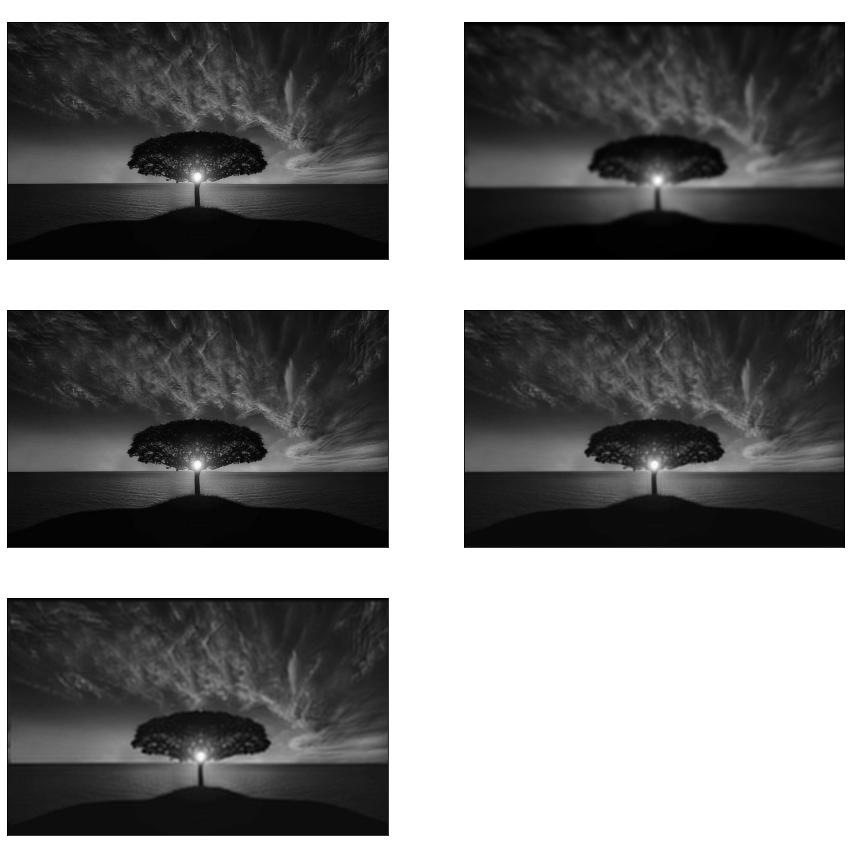

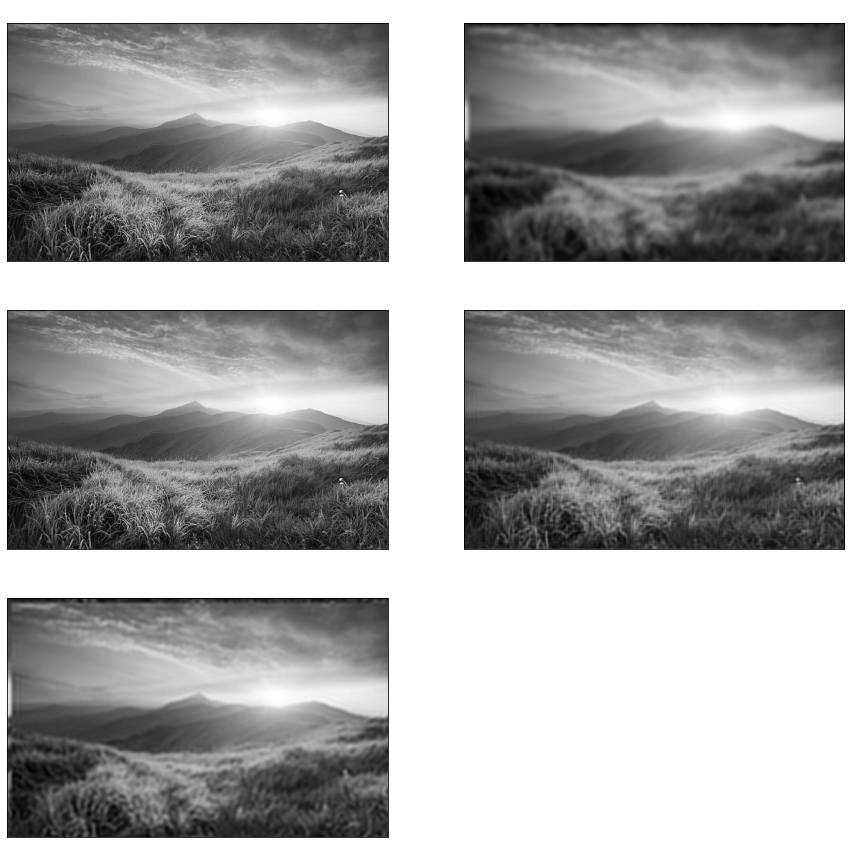

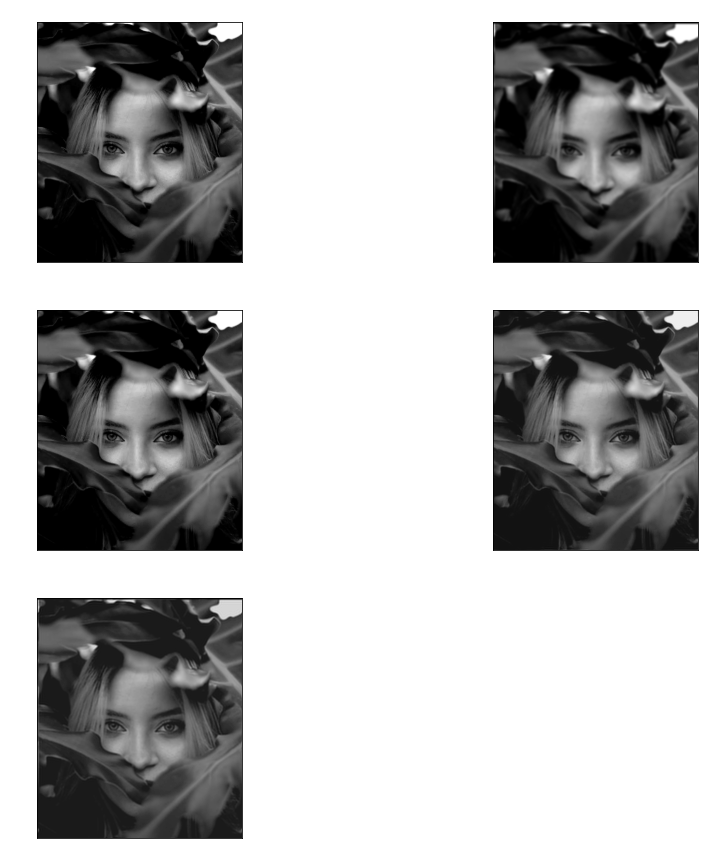

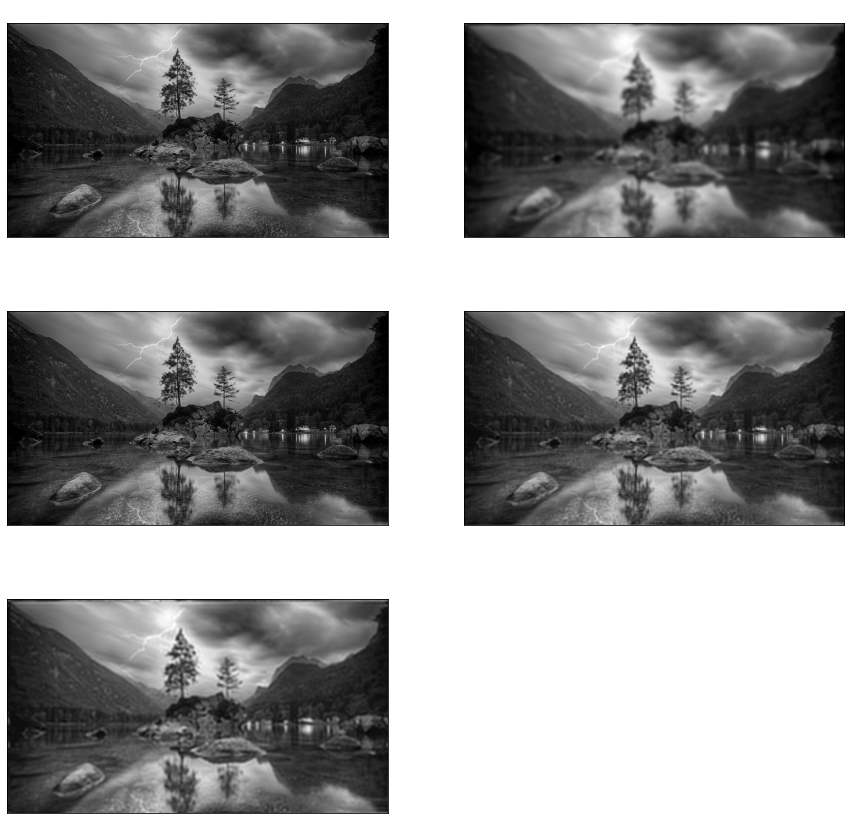

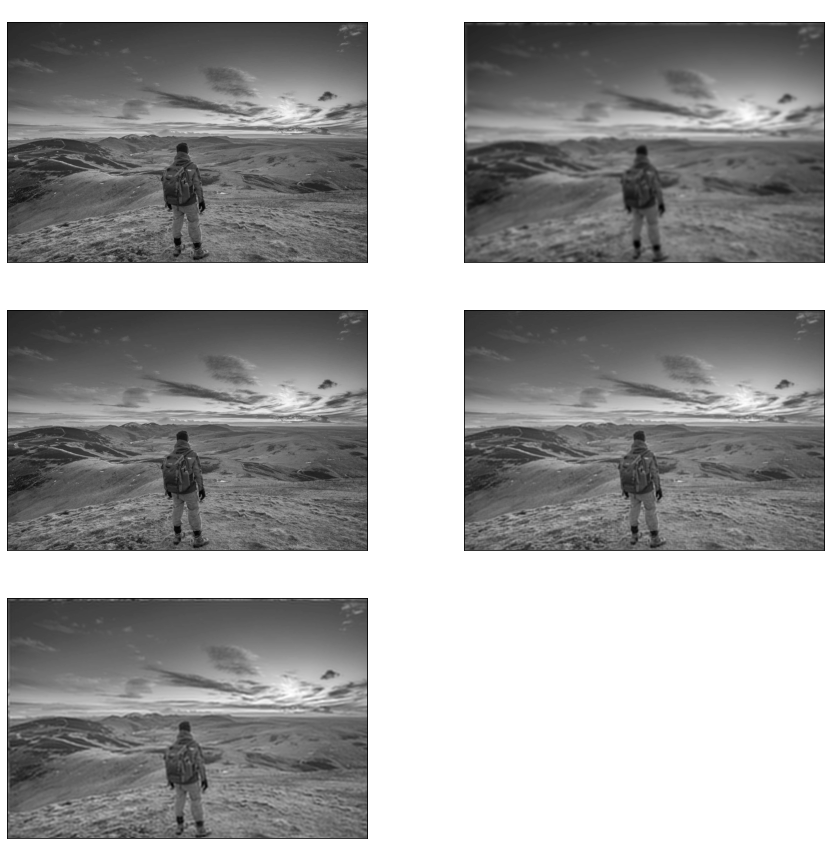

In [104]:
kernelLen = 15
sigma = 3
iterations = 100

for imagefile in filter(lambda x: x.endswith('.jpg'), os.listdir('.')):
    # Citim imaginea
    image = cv.imread(imagefile)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255
    
    # Aplicam blur
    blur_img = blur_image(image, kernelLen, sigma)

    # Aplicam Inverse Filter pentru deblurare
    deblur_inv = InverseFilter(blur_img, kernelLen, sigma)

    # Aplicam Wiener Filter pentru deblurare
    deblur_w = WienerFilter(blur_img, 0.0001, kernelLen, sigma)

    # Aplicam Richardson-Lucy pentru deblurare
    img_rl = richardsonLucy(np.abs(blur_img), iterations, kernelLen, sigma).real

    # Rezultate
    plt.rcParams['figure.figsize']=(15,15)
    fig = plt.figure()

    # Imaginea originala
    fig_orgl = fig.add_subplot(321)
    fig_orgl.set_title('Original Image', color='white')
    fig_orgl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_orgl.imshow(image,cmap='gray')

    # imaginea blurata
    fig_blur = fig.add_subplot(322)
    fig_blur.set_title('Blurred Image', color='white')
    fig_blur.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_blur.imshow(blur_img,cmap='gray')

    # Imaginea deblurata cu Inverse Filter
    fig_deblur_inv = fig.add_subplot(323)
    fig_deblur_inv.set_title('Image deblurred with Inverse Filter', color='white')
    fig_deblur_inv.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_inv.imshow(deblur_inv,cmap='gray')

    # Imaginea deblurata cu Wiener Filter
    fig_deblur_w = fig.add_subplot(324)
    fig_deblur_w.set_title('Image deblurred with Wiener Filter', color='white')
    fig_deblur_w.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_w.imshow(deblur_w,cmap='gray')

    # Imaginea deblurata cu Richardson-Lucy
    fig_deblur_rl = fig.add_subplot(325)
    fig_deblur_rl.set_title('Image deblurred with Richardson-Lucy filter', color='white')
    fig_deblur_rl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_rl.imshow(img_rl,cmap='gray')

### Deblurare (cu zgomot)

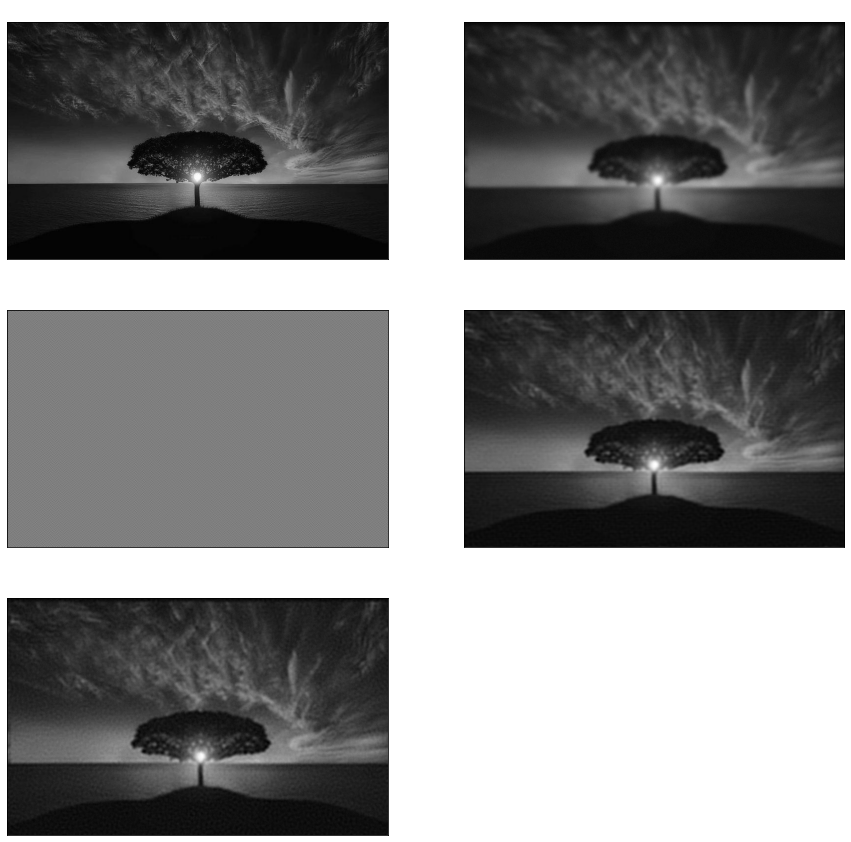

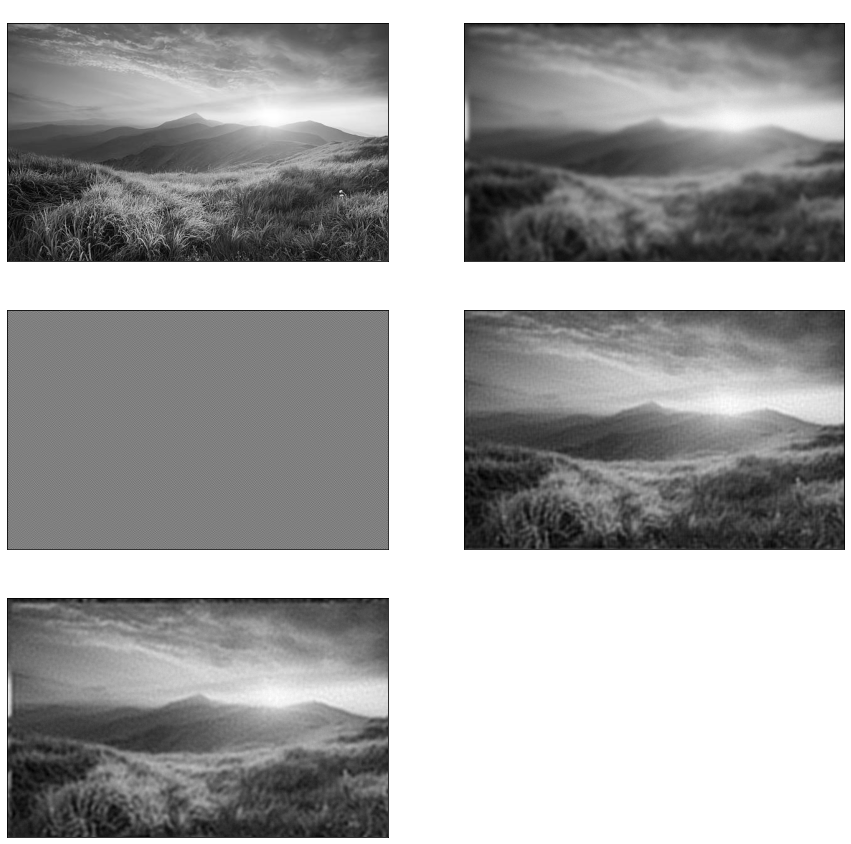

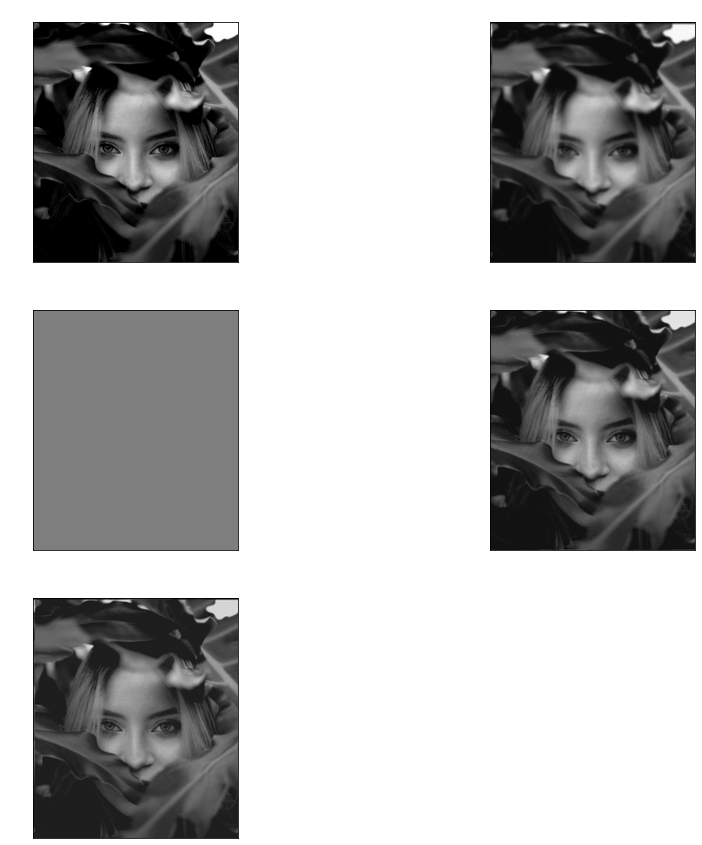

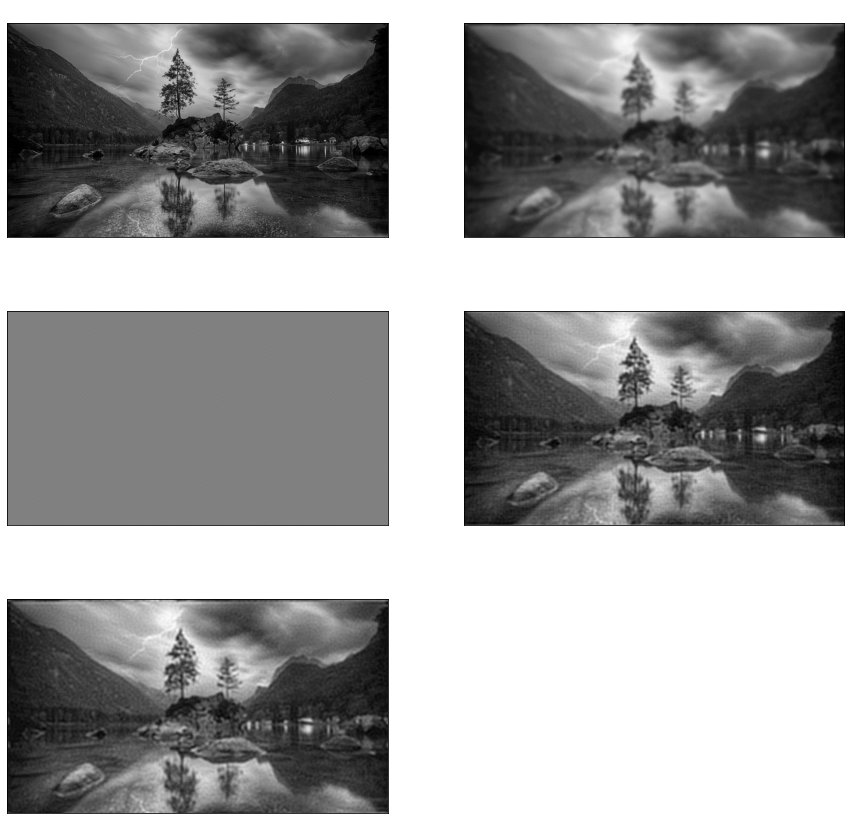

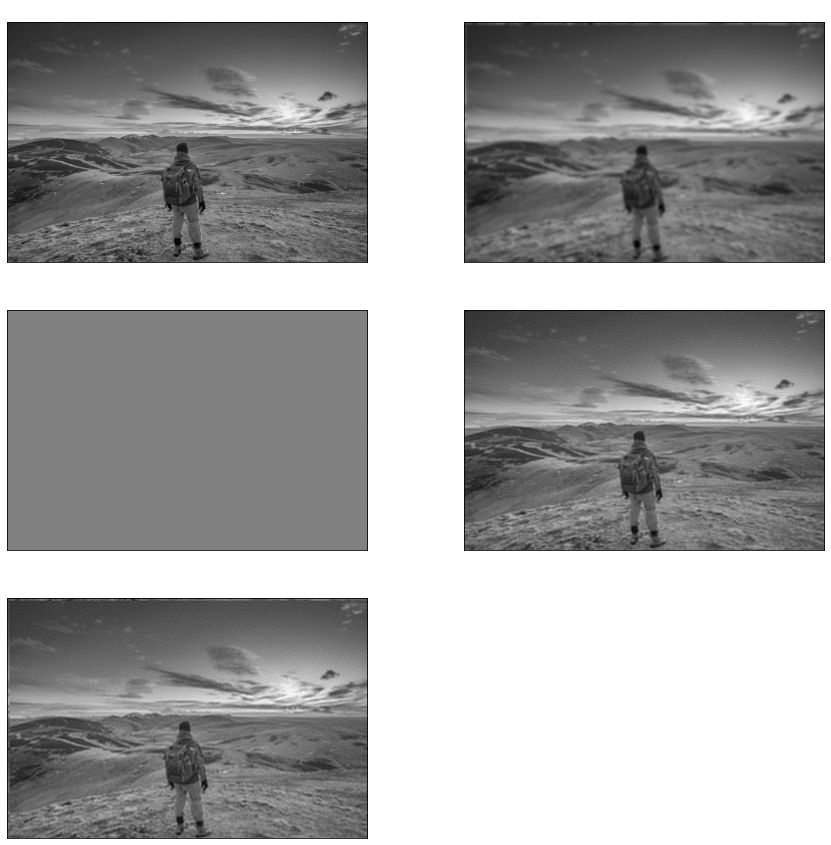

In [119]:
kernelLen = 15
sigma = 3
iterations = 100

for imagefile in filter(lambda x: x.endswith('.jpg'), os.listdir('.')):
    # Citim imaginea
    image = cv.imread(imagefile)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255

    # Aplicam filtrul de blur pe imagine
    blur_img = blur_image(image, kernelLen, sigma)

    # Aplicam efectul de noise
    noise_ = noise(blur_img)
    noisy_img = blur_img + noise_

    # Aplicam InverseFilter pentru deblurare
    deblur_inv = InverseFilter(noisy_img, kernelLen, sigma)

    # Aplicam Wiener Filter pentru deblurare cu un NSR calculat
    nsr = NSR(image, noise_)
    deblur_w = WienerFilter(noisy_img, nsr, kernelLen, sigma)

    # Aplicam Richardson-Lucy Filter pentru deblurare
    img_rl = richardsonLucy(np.abs(noisy_img), iterations, kernelLen, sigma).real

    # Rezultate
    plt.rcParams['figure.figsize']=(15,15)
    fig = plt.figure()

    # Imaginea originala
    fig_orgl = fig.add_subplot(321)
    fig_orgl.set_title('Original Image', color='white')
    fig_orgl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_orgl.imshow(image,cmap='gray')

    # Imaginea blurata + noise
    fig_blur = fig.add_subplot(322)
    fig_blur.set_title('Noisy Image', color='white')
    fig_blur.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_blur.imshow(noisy_img,cmap='gray')

    # Imaginea deblurata cu Inverse Filter
    fig_deblur_inv = fig.add_subplot(323)
    fig_deblur_inv.set_title('Image deblurred with inverse filter', color='white')
    fig_deblur_inv.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_inv.imshow(deblur_inv,cmap='gray')

    # Imaginea deblurata cu Wiener Filter
    fig_deblur_w = fig.add_subplot(324)
    fig_deblur_w.set_title('Image deblurred with wiener filter', color='white')
    fig_deblur_w.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_w.imshow(deblur_w,cmap='gray')

    # Imaginea deblurata cu Richardson-Lucy
    fig_deblur_rl = fig.add_subplot(325)
    fig_deblur_rl.set_title('Image deblurred with richardson lucy filter', color='white')
    fig_deblur_rl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_rl.imshow(img_rl,cmap='gray')

### Grafice

In [106]:
def evaluate_noNoise(filename,blur):
    # Citeste imaginea
    image = cv.imread(imagefile)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255

    # Aplica blur
    newimage = blur_image(image, blur*5, blur)    
    
    # Aplica filtrele de deconvolutie
    image_1 = InverseFilter(newimage, kernelLen, sigma)  
    image_2 = WienerFilter(newimage, 0.042, kernelLen, sigma)
    image_3 = richardsonLucy(newimage, iterations, kernelLen, sigma)
    
    # Calculeaza metricile de evaluare
    l1.append(mean_squared_error(image,image_1))
    l2.append(mean_squared_error(image,image_2))
    l3.append(mean_squared_error(image,image_3))
    l4.append(peak_signal_noise_ratio(image,image_1))
    l5.append(peak_signal_noise_ratio(image,image_2))
    l6.append(peak_signal_noise_ratio(image,image_3))

    return

# Listele de puncte pentru grafice
l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []

# Calculeaza punctele graficelor pentru una din poze
for i in range(4,18):
    evaluate_noNoise("photo_1.jpg", i)

### Variatia MSE in functie de blur pentru imaginile fara zgomot



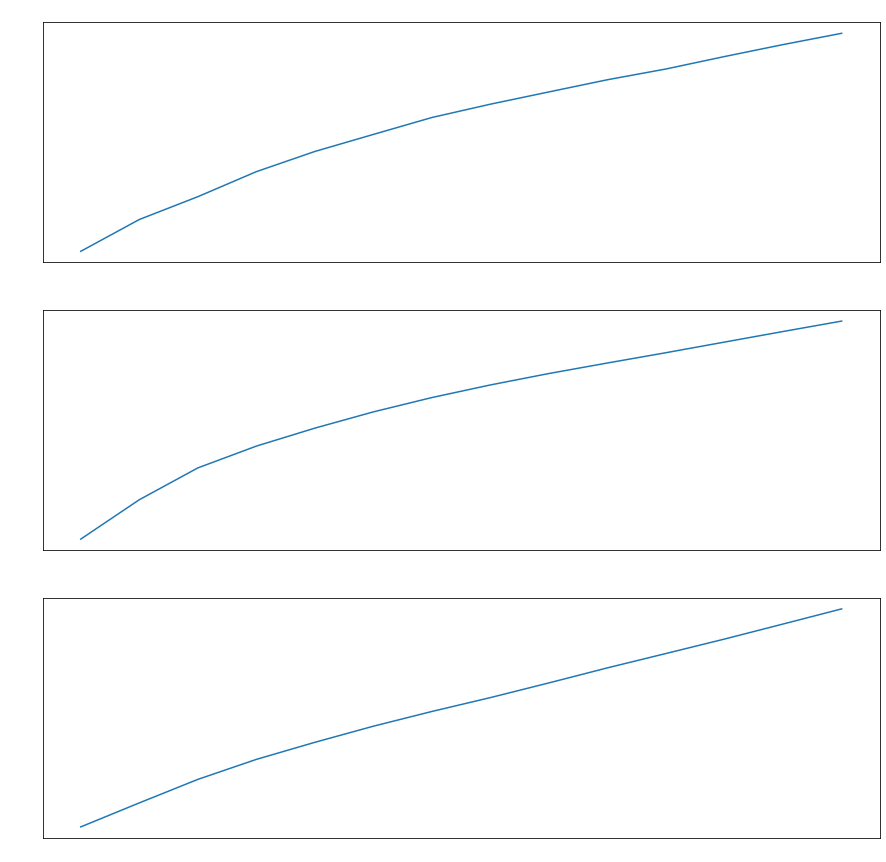

In [107]:
x = [4,5,6,7,8,9,10,11,12,13,14, 15, 16, 17]
fig = plt.figure()

# MSE pentru Inverse Filter
figl_noNoise = fig.add_subplot(311)
figl_noNoise.set_title('MSE Inverse Filter', color='white')
figl_noNoise.tick_params(axis='x', colors='white')
figl_noNoise.tick_params(axis='y', colors='white')
figl_noNoise.plot(x[:],l1[:])

# MSE pentru Wiener Filter
fig2 = fig.add_subplot(312)
fig2.set_title('MSE Weiner Filter', color='white')
fig2.tick_params(axis='x', colors='white')
fig2.tick_params(axis='y', colors='white')
fig2.plot(x[:],l2[:])

# MSE pentru Richardson-Lucy Filter
fig3 = fig.add_subplot(313)
fig3.set_title('MSE Richarson-Lucy Filter', color='white')
fig3.tick_params(axis='x', colors='white')
fig3.tick_params(axis='y', colors='white')
fig3.plot(x[:],l3[:])

### Variatia PSNR in functie de blur pentru imaginile fara zgomot

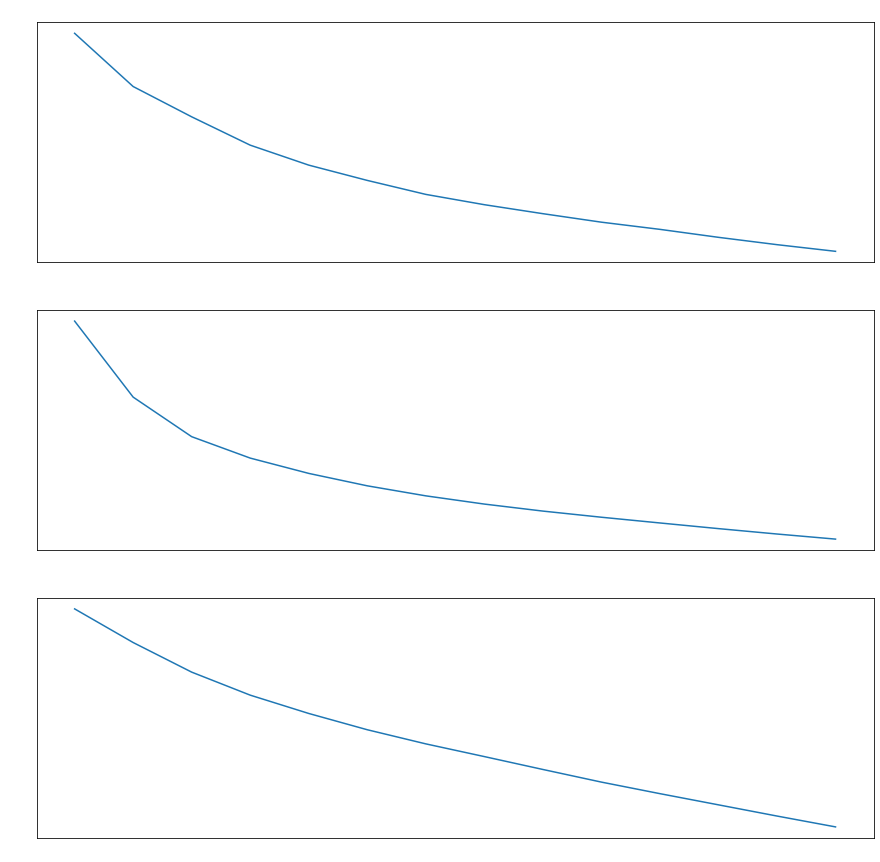

In [108]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
fig = plt.figure()

# PSNR pentru Inverse Filter
figl_noNoise = fig.add_subplot(311)
figl_noNoise.set_title('PSNR Inverse Filter', color='white')
figl_noNoise.tick_params(axis='x', colors='white')
figl_noNoise.tick_params(axis='y', colors='white')
figl_noNoise.plot(x[:],l4[:])

# PSNR pentru Wiener Filter
fig2_noNoise = fig.add_subplot(312)
fig2_noNoise.set_title('PSNR Weiner Filter', color='white')
fig2_noNoise.tick_params(axis='x', colors='white')
fig2_noNoise.tick_params(axis='y', colors='white')
fig2_noNoise.plot(x[:],l5[:])

# PSNR pentru Richardson-Lucy Filter
fig3_noNoise = fig.add_subplot(313)
fig3_noNoise.set_title('PSNR Richarson-Lucy Filter', color='white')
fig3_noNoise.tick_params(axis='x', colors='white')
fig3_noNoise.tick_params(axis='y', colors='white')
fig3_noNoise.plot(x[:],l6[:])

In [109]:
def evaluate(filename,sig):
    # Citim imaginea
    image = cv.imread(imagefile)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255

    # Aplicam filtrele de zgomot si blur
    newimage = blur_image(image, kernelLen, sigma)    
    n = noise(image, sig)
    newimage = newimage + n
    
    # Aplicam filtrele de deconvolutie
    image_1 = InverseFilter(newimage, kernelLen, sigma)  
    image_2 = WienerFilter(newimage, 0.042, kernelLen, sigma)
    image_3 = richardsonLucy(newimage, iterations, kernelLen, sigma)
    
    # Calculam metricile de evaluare
    l1.append(mean_squared_error(image,image_1))
    l2.append(mean_squared_error(image,image_2))
    l3.append(mean_squared_error(image,image_3))
    l4.append(peak_signal_noise_ratio(image,image_1))
    l5.append(peak_signal_noise_ratio(image,image_2))
    l6.append(peak_signal_noise_ratio(image,image_3))

    return

# Listele de puncte pentru grafice
l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []

# Calculam punctele graficelor
for i in range(1, 15):
    evaluate("photo_1.jpg",0.01*i)

### Variatia MSE in functie de zgomot

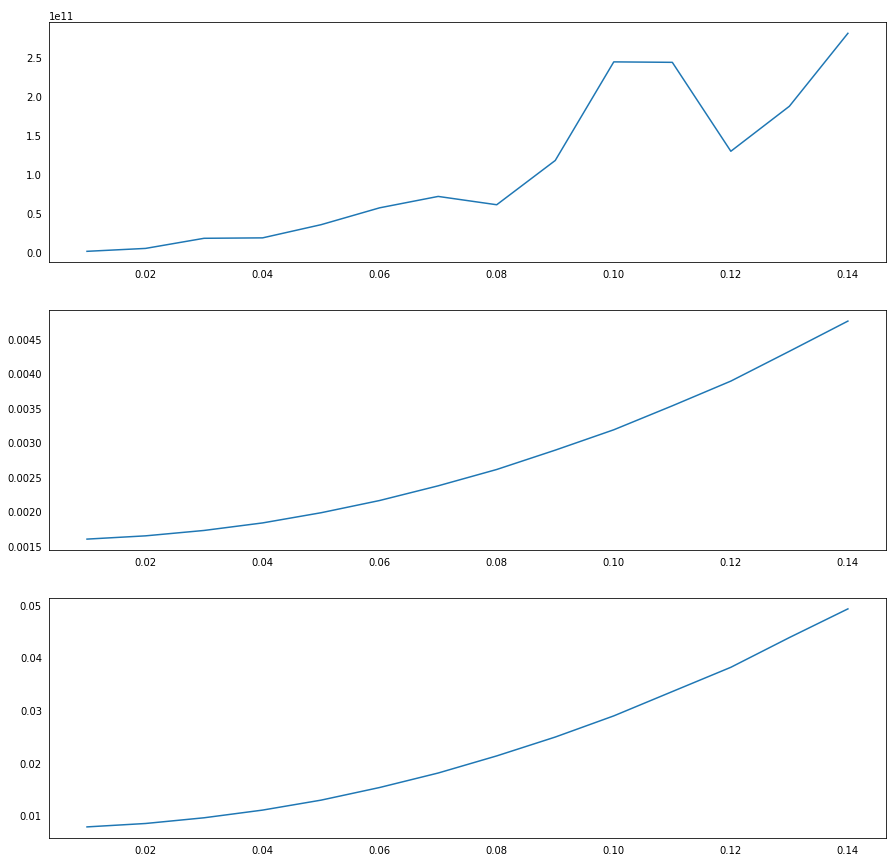

In [110]:
x = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14]
fig = plt.figure()

# MSE pentru Inverse Filter
figl_noisy = fig.add_subplot(311)
figl_noisy.set_title('MSE Inverse Filer', color='white')
figl_noisy.tick_params(axis='x', color='white')
figl_noisy.tick_params(axis='y', color='white')
figl_noisy.plot(x[:],l1[:])

# MSE pentru Wiener Filter
fig2_noisy = fig.add_subplot(312)
fig2_noisy.set_title('MSE Weiner Filter', color='white')
fig2_noisy.tick_params(axis='x', color='white')
fig2_noisy.tick_params(axis='y', color='white')
fig2_noisy.plot(x[:],l2[:])

# MSE pentru Richardson-Lucy Filter
fig3_noisy = fig.add_subplot(313)
fig3_noisy.set_title('MSE Richarson-Lucy Filter', color='white')
fig3_noisy.tick_params(axis='x', color='white')
fig3_noisy.tick_params(axis='y', color='white')
fig3_noisy.plot(x[:],l3[:])

### Variatia PSNR in functie de zgomot

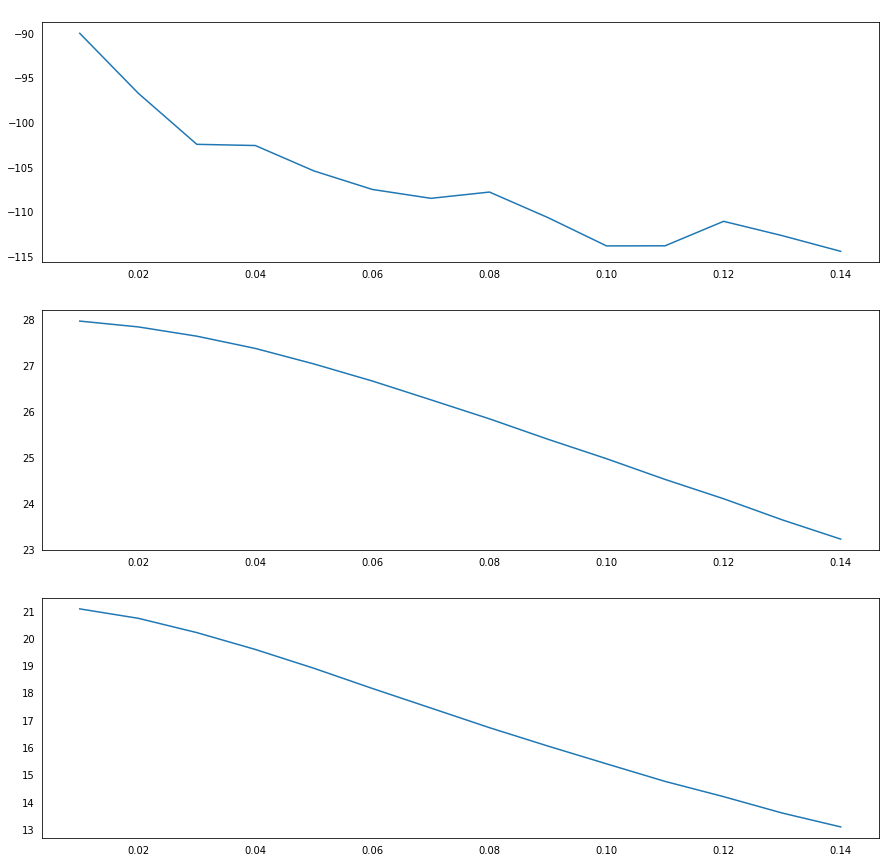

In [111]:
x = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14]
fig = plt.figure()

# PSNR pentru Inverse Filter
figl_noisy = fig.add_subplot(311)
figl_noisy.set_title('PSNR Inverse', color='white')
figl_noisy.tick_params(axis='x', color='white')
figl_noisy.tick_params(axis='y', color='white')
figl_noisy.plot(x[:],l4[:])

# PSNR pentru Wiener Filter
fig2_noisy = fig.add_subplot(312)
fig2_noisy.set_title('PSNR Weiner', color='white')
fig2_noisy.tick_params(axis='x', color='white')
fig2_noisy.tick_params(axis='y', color='white')
fig2_noisy.plot(x[:],l5[:])

# PSNR pentru Richardson-Lucy Filter
fig3_noisy = fig.add_subplot(313)
fig3_noisy.set_title('PSNR Richarson Lucy', color='white')
fig3_noisy.tick_params(axis='x', color='white')
fig3_noisy.tick_params(axis='y', color='white')
fig3_noisy.plot(x[:],l6[:])

In [112]:
def evaluate(filename,blur):
    # Citim imaginea
    image = cv.imread(imagefile)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255

    # Aplicam filtrele de noise si blur
    newimage = blur_image(image, blur*5, blur)
    n = noise(image)
    newimage = newimage + n
    
    # Aplicam filtrele de deconvolutie
    image_1 = InverseFilter(newimage, kernelLen, sigma)  
    image_2 = WienerFilter(newimage, 0.042, kernelLen, sigma)
    image_3 = richardsonLucy(newimage, iterations, kernelLen, sigma)
    
    # Calculam metricile de evaluare
    l1.append(mean_squared_error(image,image_1))
    l2.append(mean_squared_error(image,image_2))
    l3.append(mean_squared_error(image,image_3))
    l4.append(peak_signal_noise_ratio(image,image_1))
    l5.append(peak_signal_noise_ratio(image,image_2))
    l6.append(peak_signal_noise_ratio(image,image_3))
    
    return

# Listele de puncte pentru grafice
l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []

# Calculam punctele graficelor pentru o poza
for i in range(4,18):
    evaluate("photo_1.jpg",i)

### Variatia MSE in functie de blur pentru imaginile cu zgomot

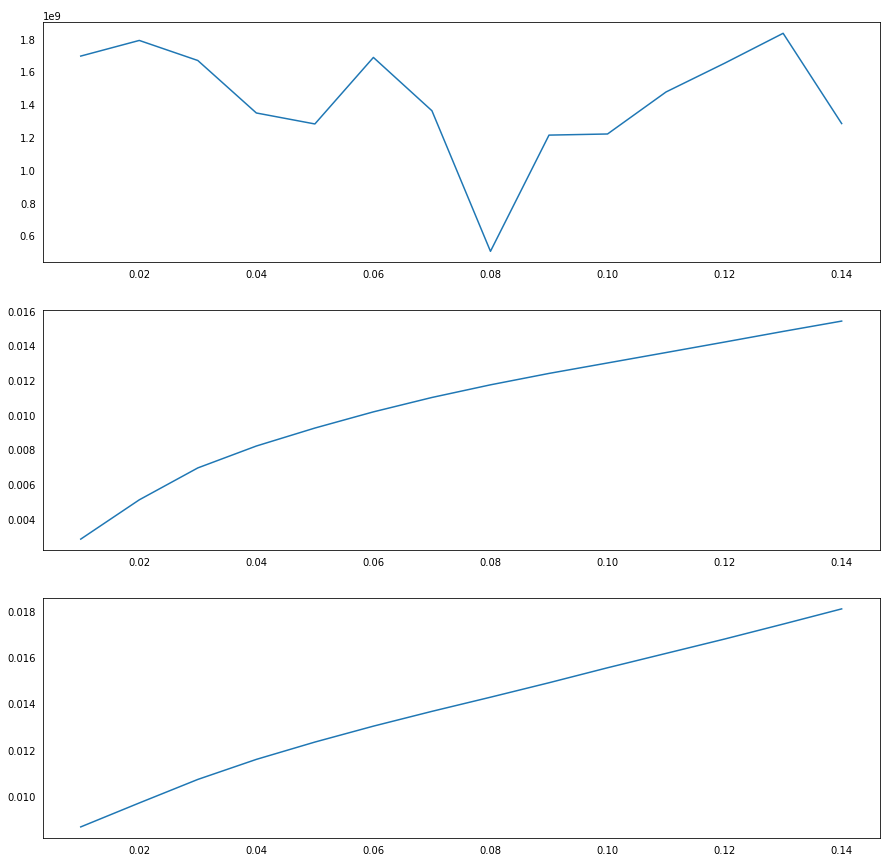

In [113]:
x = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14]
fig = plt.figure()

# MSE pentru Inverse Filter
fig1_blurNoise = fig.add_subplot(311)
fig1_blurNoise.set_title('MSE Inverse Filter', color='white')
fig1_blurNoise.tick_params(axis='x', color='white')
fig1_blurNoise.tick_params(axis='y', color='white')
fig1_blurNoise.plot(x[:],l1[:])

# MSE pentru Wiener Filter
fig2_blurNoise = fig.add_subplot(312)
fig2_blurNoise.set_title('MSE Weiner Filter', color='white')
fig2_blurNoise.tick_params(axis='x', color='white')
fig2_blurNoise.tick_params(axis='y', color='white')
fig2_blurNoise.plot(x[:],l2[:])

# MSE pentru Richardson-Lucy Filter
fig3_blurNoise = fig.add_subplot(313)
fig3_blurNoise.set_title('MSE Richarson Lucy', color='white')
fig3_blurNoise.tick_params(axis='x', color='white')
fig3_blurNoise.tick_params(axis='y', color='white')
fig3_blurNoise.plot(x[:],l3[:])

### Variatia PSNR in functie de blur pentru imaginile cu zgomot

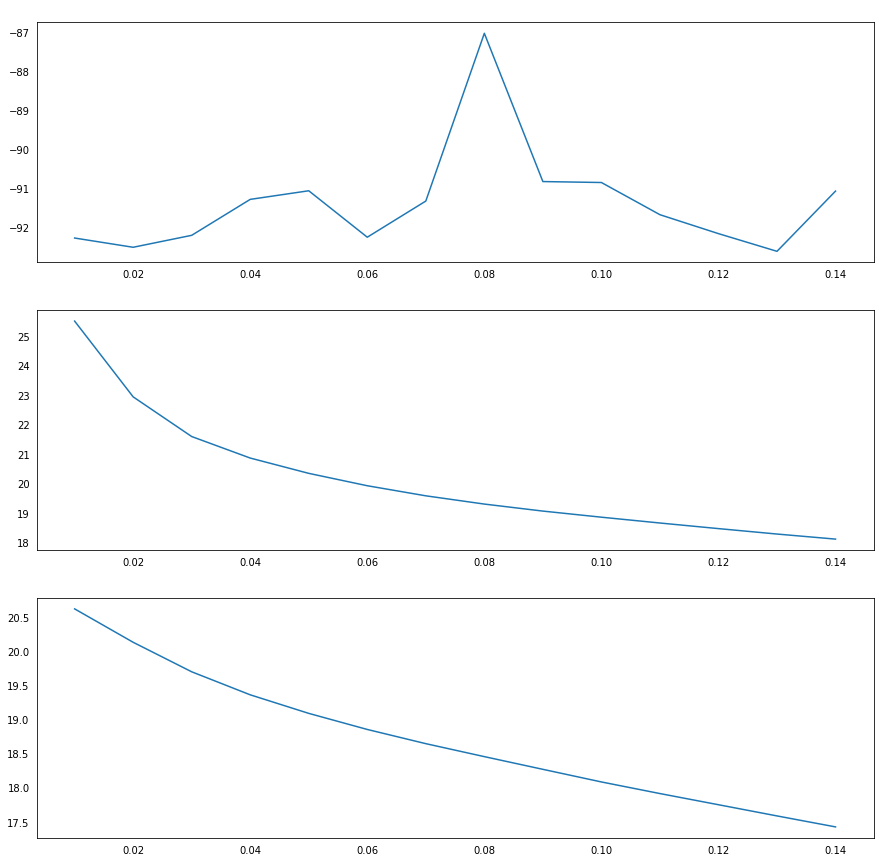

In [114]:
x = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14]
fig = plt.figure()

# Inverse Filter
fig1_blurNoise = fig.add_subplot(311)
fig1_blurNoise.set_title('PSNR Inverse Filter', color='white')
fig1_blurNoise.tick_params(axis='x', color='white')
fig1_blurNoise.tick_params(axis='y', color='white')
fig1_blurNoise.plot(x[:],l4[:])

# Wiener Filter
fig2_blurNoise = fig.add_subplot(312)
fig2_blurNoise.set_title('PSNR Weiner Filter', color='white')
fig2_blurNoise.tick_params(axis='x', color='white')
fig2_blurNoise.tick_params(axis='y', color='white')
fig2_blurNoise.plot(x[:],l5[:])

# Richardson-Lucy Filter
fig3_blurNoise = fig.add_subplot(313)
fig3_blurNoise.set_title('PSNR Richarson-Lucy Filter', color='white')
fig3_blurNoise.tick_params(axis='x', color='white')
fig3_blurNoise.tick_params(axis='y', color='white')
fig3_blurNoise.plot(x[:],l6[:])